# N-BEATS
In this notebook, we show an example of how **N-BEATS** can be used with darts. If you are new to darts, we recommend you first follow the `darts-intro.ipynb` notebook. 

**N-BEATS** is a state-of-the-art model that shows the potential of **pure DL architectures** in the context of the time-series forecasting. It outperforms well-established statistical approaches on the *M3*, and *M4* competitions. For more details on the model, see: https://arxiv.org/pdf/1905.10437.pdf.

In [31]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score

In [33]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8,5))
    if (start_date):
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label='actual')
    pred_series.plot(label=('historic ' + forecast_type + ' forecasts'))
    plt.title('R2: {}'.format(r2_score(ts_transformed.univariate_component(0), pred_series)))
    plt.legend();

## Daily energy generation example

We test NBEATS on a daily energy generation dataset from a Run-of-river power plant, as it exhibits various levels of seasonalities

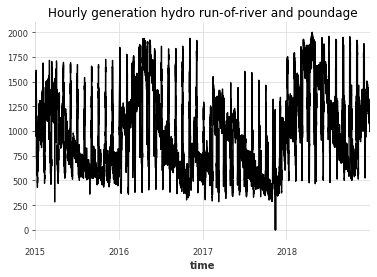

In [34]:
df = pd.read_csv('energy_dataset.csv', delimiter=",")
df['time'] = pd.to_datetime(df['time'], utc=True)
df['time']= df.time.dt.tz_localize(None)
df.set_index('time')['generation hydro run-of-river and poundage'].plot()
plt.title('Hourly generation hydro run-of-river and poundage');

To simplify things, we work with the daily generation, and we fill the missing values present in the data by using the `MissingValuesFiller`:

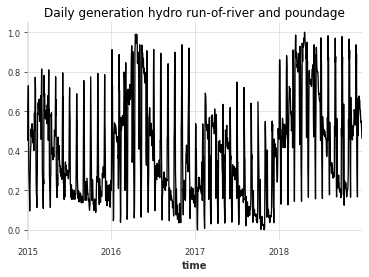

In [35]:
df_day_avg = df.groupby(df['time'].astype(str).str.split(" ").str[0]).mean().reset_index()
filler = MissingValuesFiller()
scaler = Scaler()
series = scaler.fit_transform(
    filler.transform(
        TimeSeries.from_dataframe(
            df_day_avg, 'time', ['generation hydro run-of-river and poundage'])
    )
)
series.plot()
plt.title('Daily generation hydro run-of-river and poundage');

We split the data into train and validation sets. Normally we would need to use an additional test set to validate the model on unseen data, but we will skip it for this example.

In [36]:
train, val = series.split_after(pd.Timestamp('20170901'))

In [37]:
train_enhanced = train.add_holidays('US')
val_enhanced = val.add_holidays('US')

### Generic architecture

N-BEATS is a univariate model architecture that offers two configurations: a *generic* one and a *interpretable* one. The **generic architecture**  uses as little prior knowledge as possible, with no feature engineering, no scaling and no internal architectural components that may be considered time-series-specific. 

To start off, we use a model with the generic architecture of N-BEATS:

In [38]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name='nbeats_run'
)

In [39]:
model_nbeats.fit(train, val_series=val, verbose=True)

[2021-02-05 14:41:05,842] INFO | darts.models.torch_forecasting_model | Train dataset contains 940 samples.
[2021-02-05 14:41:05,842] INFO | darts.models.torch_forecasting_model | Train dataset contains 940 samples.
INFO:darts.models.torch_forecasting_model:Train dataset contains 940 samples.


Training loss: 0.0097, validation loss: 0.0194, best val loss: 0.0194


Let's see the historical forecasts the model would have produced with an expanding training window, and a forecasting horizon of 7:

[2021-02-05 14:42:20,598] WARNING | darts.timeseries | The inferred frequency does not match the value of the "freq" argument.


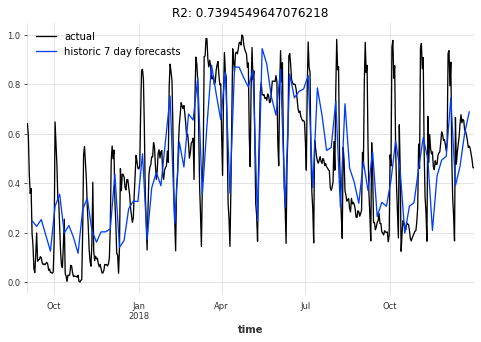

In [40]:
pred_series = model_nbeats.historical_forecasts(
    series,
    start=pd.Timestamp('20170901'), 
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True
)
display_forecast(pred_series, series['0'], '7 day', start_date=pd.Timestamp('20170901'))

In [9]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name='nbeats_run'
)
model_nbeats.fit(train_enhanced, val_series=val_enhanced, verbose=True)

[2021-02-04 16:03:08,226] INFO | darts.models.torch_forecasting_model | Train dataset contains 940 samples.
[2021-02-04 16:03:08,226] INFO | darts.models.torch_forecasting_model | Train dataset contains 940 samples.


RuntimeError: mat1 and mat2 shapes cannot be multiplied (24000x2 and 30x512)

### Interpretable model

N-BEATS offers an *interpretable architecture* consisting of two stacks: A **trend** stack and a **seasonality** stack. The architecture is designed so that:
- The trend component is removed from the input  before it is fed into the seasonality stack 
- The **partial forecasts of trend and seasonality are available** as separate interpretable outputs

In [ ]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name='nbeats_interpretable_run'
)

In [ ]:
model_nbeats.fit(series=train, val_series=val, verbose=True)

Let's see the historical forecasts the model would have produced with an expanding training window, and a forecasting horizon of 7:

In [ ]:
pred_series = model_nbeats.historical_forecasts(
    series,
    start=pd.Timestamp('20170901'), 
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True
)
display_forecast(pred_series, series['0'], '7 day', start_date=pd.Timestamp('20170901'))

# Trying GluonTS

In [ ]:
from gluonts.model.n_beats import NBEATSEstimator
import gluonts

In [2]:
pip install pandas==1.0.1

     |████████████████████████████████| 9.9 MB 5.1 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.0
    Uninstalling pandas-1.1.0:
      Successfully uninstalled pandas-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
u8darts dev requires pandas==1.1.0, but you have pandas 1.0.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


<ipython-input-1-83f326b010d9>:3: DeprecationWarning: gluonts.trainer is deprecated. Use gluonts.mx.trainer instead.
  from gluonts.trainer import Trainer
  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:01<00:00, 27.53it/s, epoch=10/10, avg_epoch_loss=3.95]


[53.122032 50.00481  44.55803  45.26207  43.846313 43.487114 41.864536
 43.55284  44.68142  40.98628  44.065346 43.34086 ]


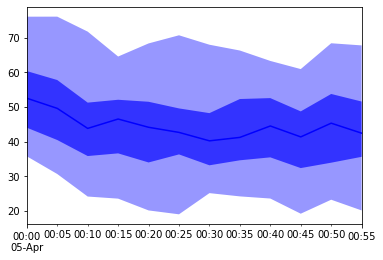

In [1]:
from gluonts.dataset import common
from gluonts.model import deepar
from gluonts.trainer import Trainer

import pandas as pd

url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"
df = pd.read_csv(url, header=0, index_col=0)
data = common.ListDataset([{
    "start": df.index[0],
    "target": df.value[:"2015-04-05 00:00:00"]
}],
                          freq="5min")

trainer = Trainer(epochs=10)
estimator = deepar.DeepAREstimator(
    freq="5min", prediction_length=12, trainer=trainer)
predictor = estimator.train(training_data=data)

prediction = next(predictor.predict(data))
print(prediction.mean)
prediction.plot(output_file='graph.png')


## Univariate test with the energy generation data

In [45]:
df = train._df

data = common.ListDataset([
    {
    "start": df.index[0],
    "target": df['0']
    }
],
                          freq="D")
data

In [46]:
estimator = NBEATSEstimator(
    freq='D', 
    prediction_length=7, 
    context_length=None, 
    trainer=gluonts.trainer._base.Trainer(
        batch_size=32, 
        clip_gradient=10.0, 
        ctx=None, epochs=100, 
        hybridize=True, 
        init="xavier", 
        learning_rate=0.001, 
        learning_rate_decay_factor=0.5, 
        minimum_learning_rate=5e-05, 
        num_batches_per_epoch=50, 
        patience=10, 
        weight_decay=1e-08
    ), 
    num_stacks=30, 
    widths=None, 
    num_blocks=None, 
    num_block_layers=None, 
    expansion_coefficient_lengths=None, 
    sharing=None, 
    stack_types=None, 
    loss_function='MAPE'
)

predictor = estimator.train(training_data=data)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:08<00:00,  5.66it/s, epoch=100/100, avg_epoch_loss=1.84]


In [ ]:
prediction = next(predictor.predict(data))
print(prediction.mean)
prediction.plot(output_file='graph.png')

## "Multivariate" approach (Or is this multi-time series?)

In [42]:
df = train_enhanced._df

data = common.ListDataset([
    {
    "start": df.index[0],
    "target": df['0']
    },
    {
    "start": df.index[0],
    "target": df['time']
    },
],
                          freq="D")
data

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:09<00:00,  5.29it/s, epoch=100/100, avg_epoch_loss=0.98]


[0.14206636 0.13960078 0.11911139 0.13982335 0.1314882  0.1352311
 0.13074306]


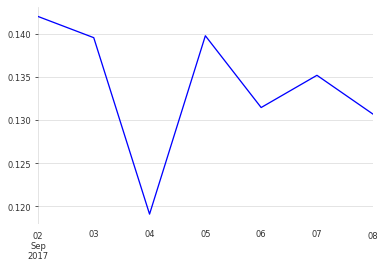

In [43]:
estimator = NBEATSEstimator(
    freq='D', 
    prediction_length=7, 
    context_length=None, 
    trainer=gluonts.trainer._base.Trainer(
        batch_size=32, 
        clip_gradient=10.0, 
        ctx=None, epochs=100, 
        hybridize=True, 
        init="xavier", 
        learning_rate=0.001, 
        learning_rate_decay_factor=0.5, 
        minimum_learning_rate=5e-05, 
        num_batches_per_epoch=50, 
        patience=10, 
        weight_decay=1e-08
    ), 
    num_stacks=30, 
    widths=None, 
    num_blocks=None, 
    num_block_layers=None, 
    expansion_coefficient_lengths=None, 
    sharing=None, 
    stack_types=None, 
    loss_function='MAPE'
)

predictor = estimator.train(training_data=data)

prediction = next(predictor.predict(data))
print(prediction.mean)
prediction.plot(output_file='graph.png')


In [44]:
prediction

gluonts.model.forecast.SampleForecast(freq="D", info=None, item_id=None, samples=numpy.array([[0.1420663595199585, 0.13960078358650208, 0.11911138892173767, 0.13982334733009338, 0.13148820400238037, 0.13523109257221222, 0.13074305653572083]], numpy.dtype("float32")), start_date=pandas.Timestamp("2017-09-02 00:00:00", freq="D"))

In [ ]:
predictor

In [ ]:
estimator = NBEATSEnsembleEstimator(
      prediction_length=prediction_length,
      #context_length=7*prediction_length,
      meta_bagging_size = 3,  # 3, ## Change back to 10 after testing??
      meta_context_length = [prediction_length * mlp for mlp in [3,5,7] ], ## Change back to (2,7) // 3,5,7
      meta_loss_function = ['sMAPE'], ## Change back to all three MAPE, MASE ...
      num_stacks = 30,
      widths= [512],
      freq="D",
      trainer=Trainer(
                    learning_rate=6e-4,
                    #clip_gradient=1.0,
                    epochs=12, #10
                    num_batches_per_epoch=1000,
                    batch_size=16
                    #ctx=mx.context.gpu()
                )

  )

predictor = estimator.train(train_ds)